# Importar Librerías

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from scipy import stats

# Cargar los Datos

In [2]:
# URL del archivo en GitHub
url = "https://raw.githubusercontent.com/Carlos123456789012/Series_De_Tiempo/refs/heads/main/Tarea2/ozono.csv"

# Leer el archivo, omitiendo la primera fila y especificando los nombres de las columnas
df = pd.read_csv(url, sep=r'[ ,]+', skiprows=1, header=None, names=['Fecha', 'Hora', 'CO2(mg/m3)'], engine='python')

# Convertir las columnas 'Fecha' y 'Hora' en una sola columna 'FechaHora' de tipo datetime
df['FechaHora'] = pd.to_datetime(df['Fecha'] + ' ' + df['Hora'], format='%m/%d/%Y %H:%M')

# Establecer 'FechaHora' como el índice y eliminar las columnas 'Fecha' y 'Hora'
df.set_index('FechaHora', inplace=True)
df.drop(columns=['Fecha', 'Hora'], inplace=True)

# Verificar que se leyeron bien los datos
print(df.head())

                     CO2(mg/m3)
FechaHora                      
2018-01-19 14:00:00        0.50
2018-01-19 15:00:00        0.46
2018-01-19 16:00:00        0.84
2018-01-19 17:00:00        0.95
2018-01-19 18:00:00        1.24


## Interpolación de Datos Faltantes

### Haremos una interpolación de los datos basada en el tiempo (`method='time'`)

**Razones:**

1. **Series Temporales con Frecuencia Regular**:  
   Dado que los datos tienen una frecuencia fija (una medición cada hora), la interpolación basada en tiempo utiliza los intervalos horarios para ajustar los valores faltantes.

2. **Patrones Estacionales o Diurnos**:  
   Este método es especialmente útil si los valores faltantes están distribuidos en diferentes épocas del día o del año, ya que utiliza los intervalos de tiempo para realizar una interpolación más adecuada para series temporales.

3. **Adecuación a Intervalos Regulares**:  
   La interpolación basada en tiempo asegura que los valores interpolados se ajusten bien a intervalos regulares, que es lo que ideal en nuestro contexto de una serie de datos que se mide a intervalos constantes como cada hora.


In [3]:
df['CO2(mg/m3)'] = df['CO2(mg/m3)'].interpolate(method='time')

# Verificar que ya no haya datos nulos
print("Datos faltantes después de la interpolación:", df['CO2(mg/m3)'].isnull().sum())

Datos faltantes después de la interpolación: 0


# Análisis del 10% de datos de la Serie Temporal

## Selección del 10% final de los Datos

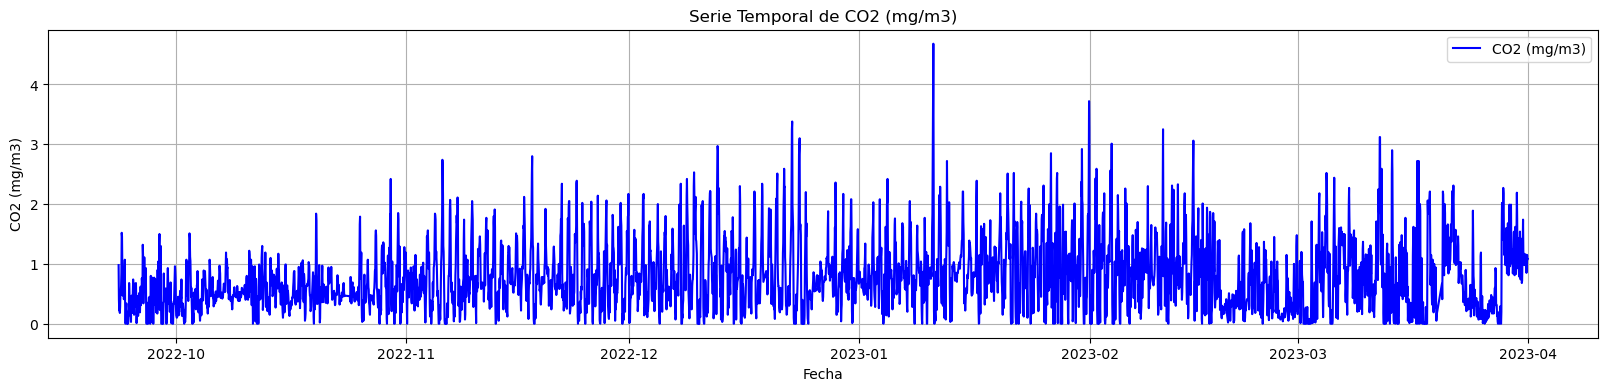

In [4]:
ultimo_decil_df = df[-int(0.1 * len(df)):]

# Gráfico del 10% de la Serie Temporal

plt.figure(figsize=(20, 4))
plt.plot(ultimo_decil_df.index, ultimo_decil_df['CO2(mg/m3)'], label='CO2 (mg/m3)', color='blue')
plt.title('Serie Temporal de CO2 (mg/m3)')
plt.xlabel('Fecha')
plt.ylabel('CO2 (mg/m3)')
plt.legend()
plt.grid()
plt.show()

***Análisis Visual de la Serie***

Al observar la gráfica de la serie de CO₂, parece que la serie no cumple con los criterios de estacionariedad:

- **Tendencia Ascendente y Picos Pronunciados**: La serie indica moverse sobre una media creciente.
- **Variabilidad Cambiante**: La variabilidad expuesta presenta incrementos graduales. Esto sugiere que la **varianza pudiese ser NO constante** a lo largo del tiempo.


## Estacionariedad

### Análisis de Estacionariedad con test de Dickey-Fuller Aumentado (ADF)

In [5]:
result = adfuller(ultimo_decil_df['CO2(mg/m3)'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Determinar si es necesario remover la estacionalidad
if result[1] > 0.05:
    print("La serie tiene raíces unitarias, ergo, NO es estacionaria.")
else:
    print("La serie no tiene raíces unitarias, ergo, es estacionaria.")

ADF Statistic: -6.954477644051031
p-value: 9.506508077145249e-10
La serie no tiene raíces unitarias, ergo, es estacionaria.


Dado que el **p-value** es muy bajo, podemos **rechazar la hipótesis nula** con un alto nivel de confianza. Esto significa que, según los resultados de la prueba ADF, **la serie es estacionaria** y no tiene una raíz unitaria. 

### Análisis de Estacionariedad con ARIMA

**El ajuste ARIMA sugiere una diferenciación**

Dado que arima sugiere d=1, analizaremos si después de aplicar una diferenciación la serie es estacionaria, pues es probable que haya una tendencia leve que el modelo ARIMA está tratando de compensar para mejorar el ajuste. La prueba ADF es sensible al ruido y puede no detectar una leve tendencia o patrones no lineales. Si la prueba ADF sugiere que la serie es estacionaria, esto significa que no tiene una raíz unitaria evidente, pero aún puede haber una tendencia leve o una variación a largo plazo que el ARIMA detecta al ajustar el modelo.

In [6]:
serie_diferenciada = ultimo_decil_df['CO2(mg/m3)'].diff().dropna()
resultado_adf_dif = adfuller(serie_diferenciada)
print('Estadístico ADF (serie diferenciada):', resultado_adf_dif[0])
print('p-valor (serie diferenciada):', resultado_adf_dif[1])
if resultado_adf_dif[1] <= 0.05:
    print("La serie diferenciada es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La serie diferenciada no es estacionaria (no podemos rechazar la hipótesis nula).")


Estadístico ADF (serie diferenciada): -19.16934138211737
p-valor (serie diferenciada): 0.0
La serie diferenciada es estacionaria (rechazamos la hipótesis nula).


### Análisis Estacionariedad a la **Serie Original** con ACF y PACF

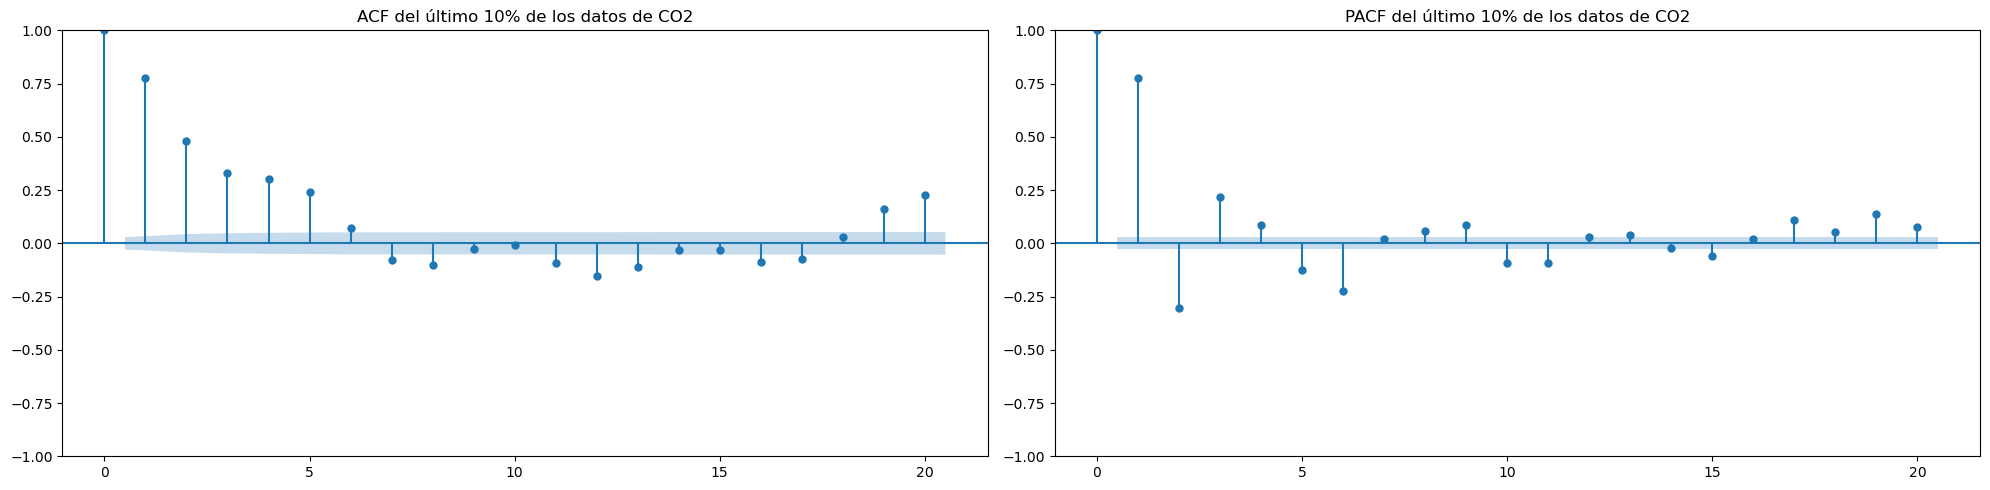

In [7]:
# Graficar ACF y PACF del último 10% de la columna 'CO2(mg/m3)'
plt.figure(figsize=(20, 5))

# Gráfico de ACF
plt.subplot(1, 2, 1)
plot_acf(ultimo_decil_df['CO2(mg/m3)'], lags=20, ax=plt.gca())
plt.title('ACF del último 10% de los datos de CO2')

# Gráfico de PACF
plt.subplot(1, 2, 2)
plot_pacf(ultimo_decil_df['CO2(mg/m3)'], lags=20, ax=plt.gca(), method='ywm')
plt.title('PACF del último 10% de los datos de CO2')

plt.tight_layout()
plt.show()

Dado que comportamiento de decaimiento lento del ACF y PACF se sugiere que la serie podría ser no estacionaria y tener una dependencia a largo plazo entre cada paso.

## Estacionalidad

Dado que la serie necesitaba una diferenciación por lo mencionado en ARIMA, para analizar la serie de una manera más adecuada, analizaremos la componente estacional a la `serie_diferenciada`. Dado el comportamiento de la serie, nos inclinaremos por una decomposición aditiva de la serie.

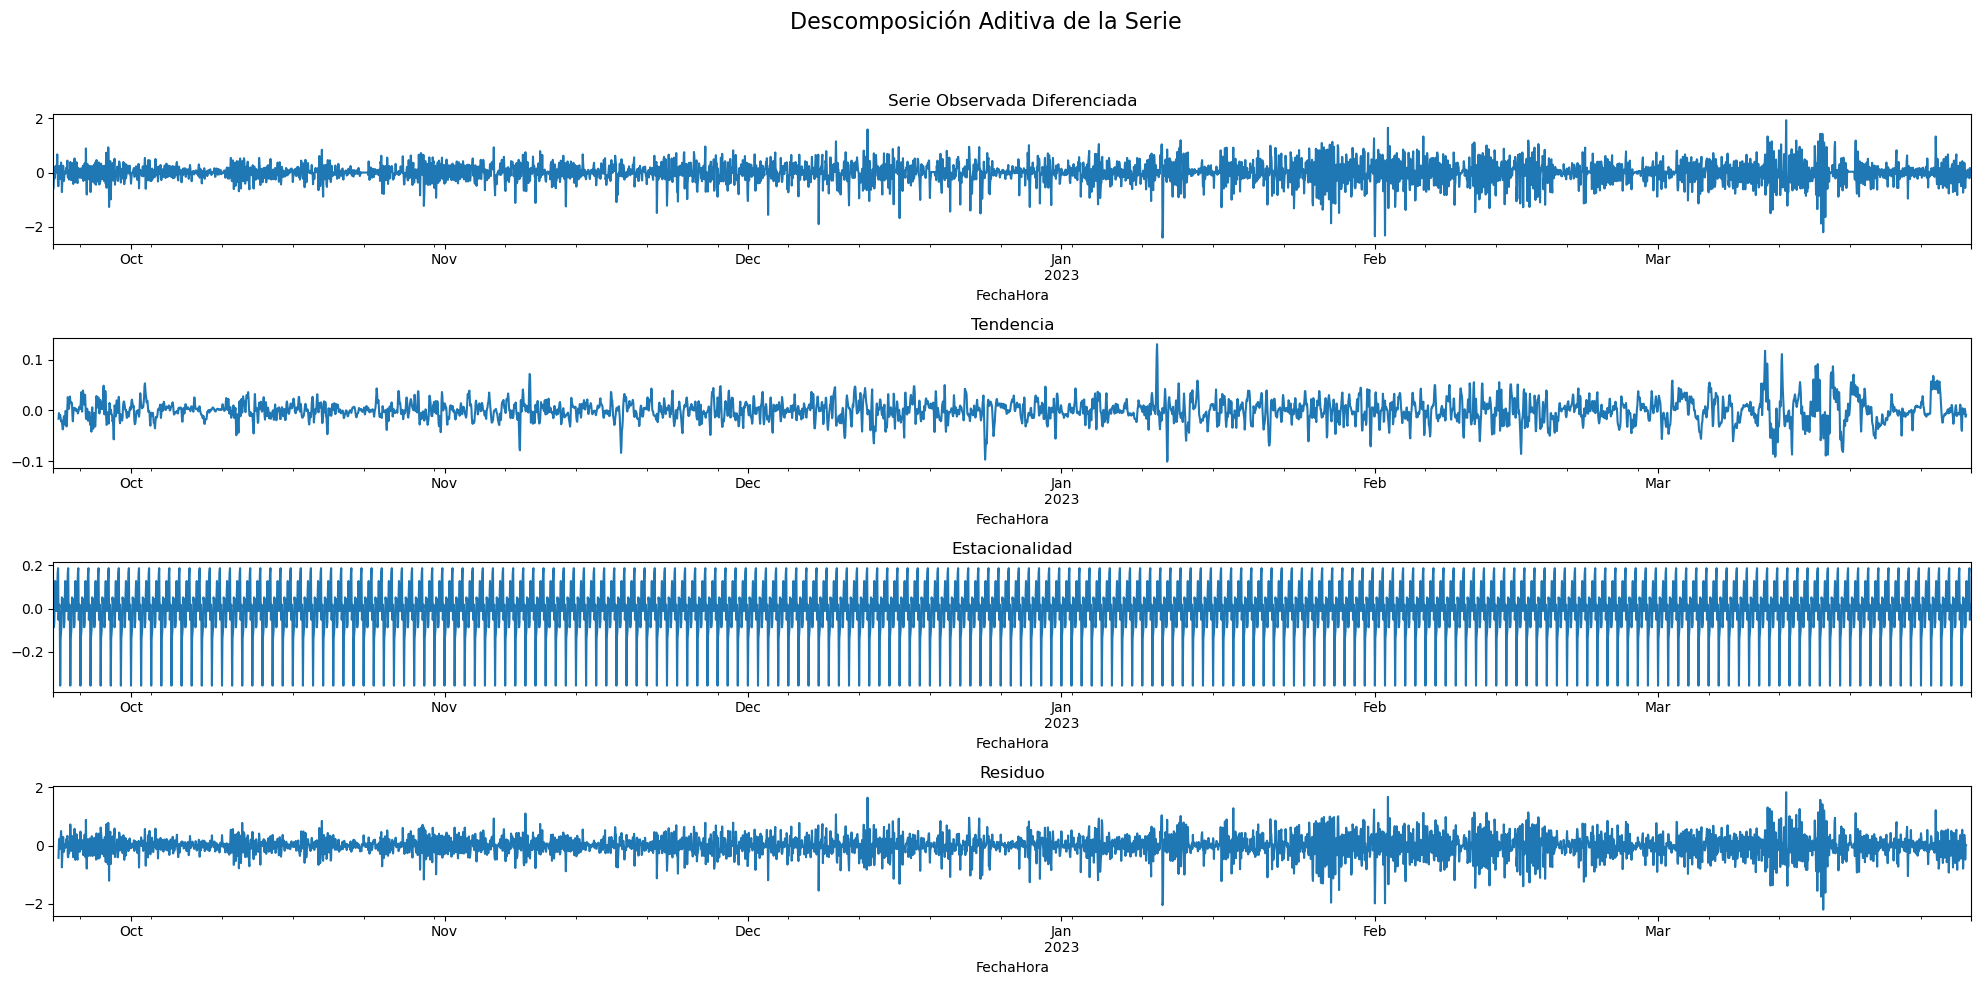

In [8]:
# Realizar la descomposición aditiva
descomposicion_aditiva = seasonal_decompose(serie_diferenciada, model='additive', period=24)  # Asumiendo estacionalidad diaria (1 ciclo completo es de 24 horas)

# Graficar la descomposición aditiva
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 10))
fig.suptitle('Descomposición Aditiva de la Serie', fontsize=16)

# Graficar las componentes con títulos
descomposicion_aditiva.observed.plot(ax=ax1, legend=False)
ax1.set_title('Serie Observada Diferenciada')

descomposicion_aditiva.trend.plot(ax=ax2, legend=False)
ax2.set_title('Tendencia')

descomposicion_aditiva.seasonal.plot(ax=ax3, legend=False)
ax3.set_title('Estacionalidad')

descomposicion_aditiva.resid.plot(ax=ax4, legend=False)
ax4.set_title('Residuo')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Comentarios sobre Estacionalidad:**

Podemos notar subidos peaks periodicos, sugiriendo que existe una componente de estacionalidad, por lo cual, será necesario quitar esta componente para un trabajo optimal con el modelo ARMA que es ineficiente con datos que presentan estacionalidad.

### Suprimir la componente Estacional de la Serie

#### Método 1: Quitar estacionalidad de la forma **SerieOriginal-ComponenteEstacionalSerie**

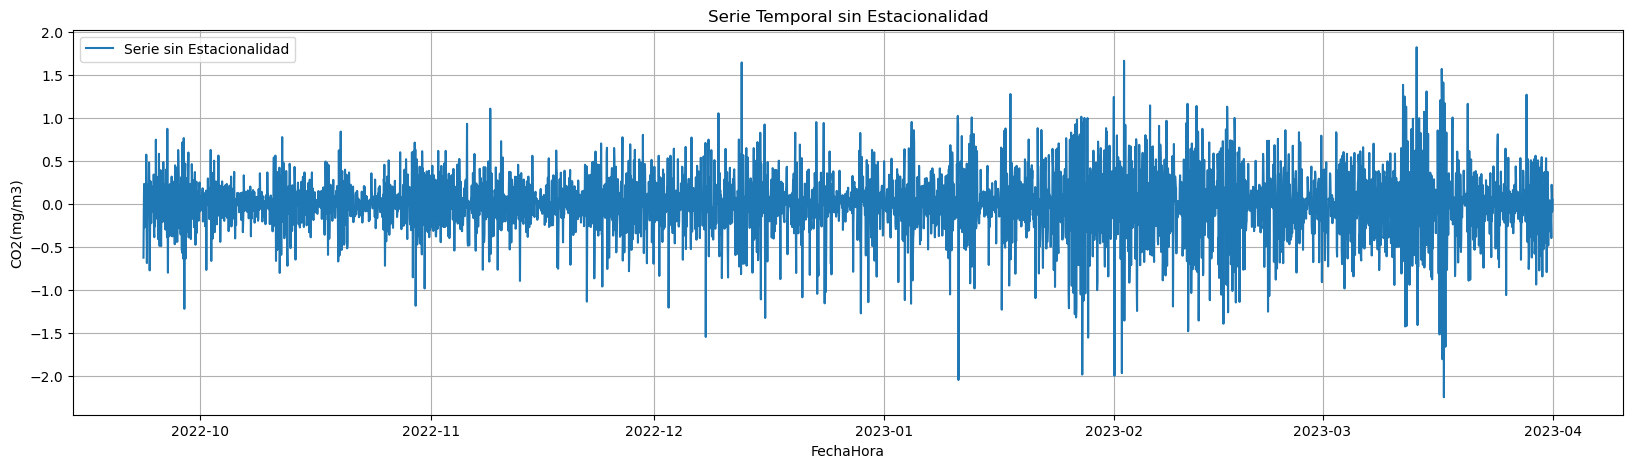

In [9]:
# Quitar la estacionalidad restando el componente estacional a la serie original
serie_sin_estacionalidad = serie_diferenciada - descomposicion_aditiva.seasonal

# Graficar la serie sin estacionalidad
plt.figure(figsize=(20, 5))
plt.plot(serie_sin_estacionalidad, label='Serie sin Estacionalidad')
plt.title('Serie Temporal sin Estacionalidad')
plt.xlabel('FechaHora')
plt.ylabel('CO2(mg/m3)')
plt.legend()
plt.grid()
plt.show()

#### Método 2: Aplicar filtro MA a la Serie

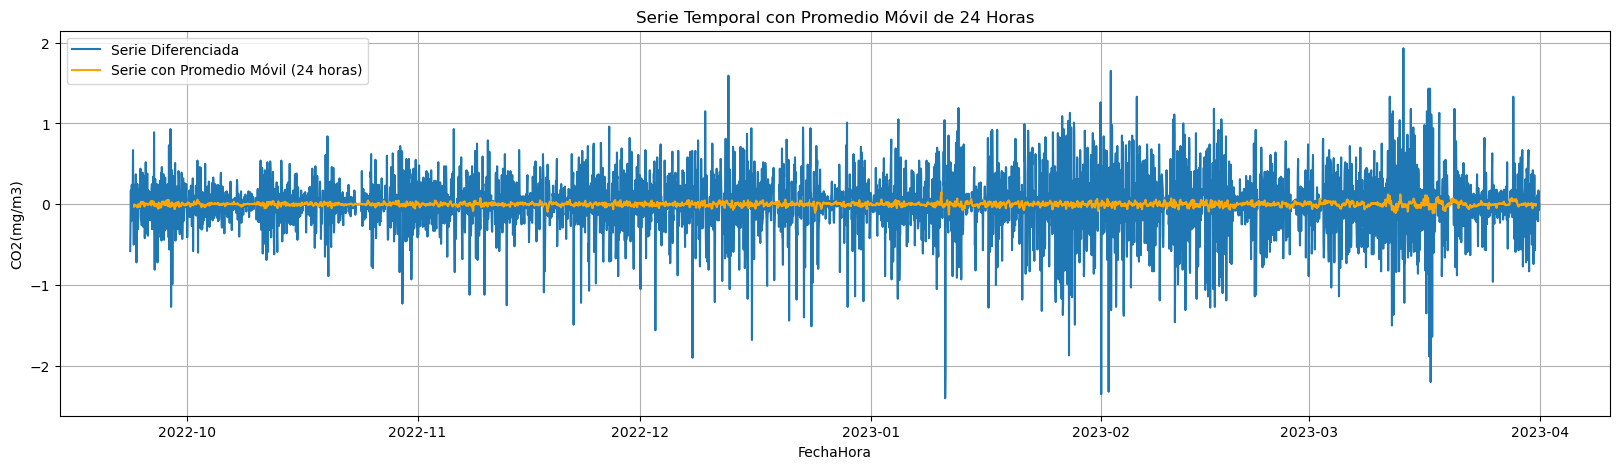

In [10]:

# Aplicar un filtro de promedio móvil con periodicidad de 24 horas
serie_promedio_movil = serie_diferenciada.rolling(window=24, center=True).mean()
# Eliminar valores NaN de la serie con promedio móvil
serie_promedio_movil = serie_promedio_movil.dropna()

# Graficar la serie original y la serie con promedio móvil
plt.figure(figsize=(20, 5))
plt.plot(serie_diferenciada, label='Serie Diferenciada')
plt.plot(serie_promedio_movil, label='Serie con Promedio Móvil (24 horas)', color='orange')
plt.title('Serie Temporal con Promedio Móvil de 24 Horas')
plt.xlabel('FechaHora')
plt.ylabel('CO2(mg/m3)')
plt.legend()
plt.grid()
plt.show()


## Ajustar modelo **ARMA(p,q)**

### Selección de Parámetros **(p,q)** mediante BIC y AIC.

In [11]:
# Aplicar auto_arima a la serie diferenciada para seleccionar los mejores parámetros p, d, q basados en AIC o BIC
modelo_auto_ultimo = auto_arima(
    serie_promedio_movil,  # La serie diferenciada
    start_p=0, 
    start_q=0,
    max_p=5, 
    max_q=5, 
    seasonal=False,  # No estacional porque la serie ya está diferenciada
    trace=True,  # Muestra el proceso de selección
    information_criterion='bic',  # Usa BIC (o cambia a 'aic' si prefieres)
    stepwise=True  # Busca los mejores parámetros de manera más eficiente
)

# Mostrar el resumen del mejor modelo encontrado
#print(modelo_auto_ultimo.summary())
# Imprimir el mejor modelo con sus valores de BIC y AIC
mejor_modelo = modelo_auto_ultimo

print(f"El mejor modelo seleccionado es ARIMA({mejor_modelo.order}) con:")
print(f"AIC = {mejor_modelo.aic():.2f}")
print(f"BIC = {mejor_modelo.bic():.2f}")

Performing stepwise search to minimize bic
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-21341.429, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=-24362.122, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=-24027.887, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=-24682.123, Time=0.38 sec
 ARIMA(3,0,0)(0,0,0)[0]             : BIC=-24772.614, Time=0.53 sec
 ARIMA(4,0,0)(0,0,0)[0]             : BIC=-24812.187, Time=0.44 sec
 ARIMA(5,0,0)(0,0,0)[0]             : BIC=-24809.487, Time=0.74 sec
 ARIMA(4,0,1)(0,0,0)[0]             : BIC=-24805.103, Time=2.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : BIC=-24787.008, Time=1.93 sec
 ARIMA(5,0,1)(0,0,0)[0]             : BIC=-24805.582, Time=2.77 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : BIC=-24803.781, Time=1.36 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0]          
Total fit time: 11.109 seconds
El mejor modelo seleccionado es ARIMA((4, 0, 0)) con:
AIC = -24844.28
BIC = -24812.19


### Análisis ARIMA directo al último 10%

In [5]:
# Aplicar auto_arima a la serie original
modelo_auto_original = auto_arima(
    ultimo_decil_df['CO2(mg/m3)'],  # La serie original sin diferenciación manual
    start_p=0, 
    start_q=0,
    max_p=5, 
    max_q=5, 
    seasonal=False,  # Mantener estacionalidad desactivada si se ha desestacionalizado previamente
    trace=True,  # Muestra el proceso de selección
    information_criterion='bic',  # Usa BIC (o cambia a 'aic' si prefieres)
    stepwise=True  # Busca los mejores parámetros de manera más eficiente
)

# Mostrar el resumen del mejor modelo encontrado
print("Modelo ajustado a la serie original:")
print(modelo_auto_original.summary())

# Imprimir el mejor modelo con AIC y BIC
mejor_modelo = modelo_auto_original
print(f"El mejor modelo seleccionado es ARIMA({mejor_modelo.order}) con:")
print(f"AIC = {mejor_modelo.aic():.2f}")
print(f"BIC = {mejor_modelo.bic():.2f}")

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=4002.842, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=3897.065, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=3767.088, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=3994.419, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=3705.207, Time=0.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=3203.397, Time=0.99 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=3295.617, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : BIC=3166.141, Time=1.01 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : BIC=3160.622, Time=0.42 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : BIC=3162.046, Time=0.67 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : BIC=3164.445, Time=2.08 sec
 ARIMA(3,1,0)(0,0,0)[0]             : BIC=3152.199, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0]             : BIC=3287.194, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0]             : BIC=3153.623, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0]          

# Análisis del Penúltimo 10%

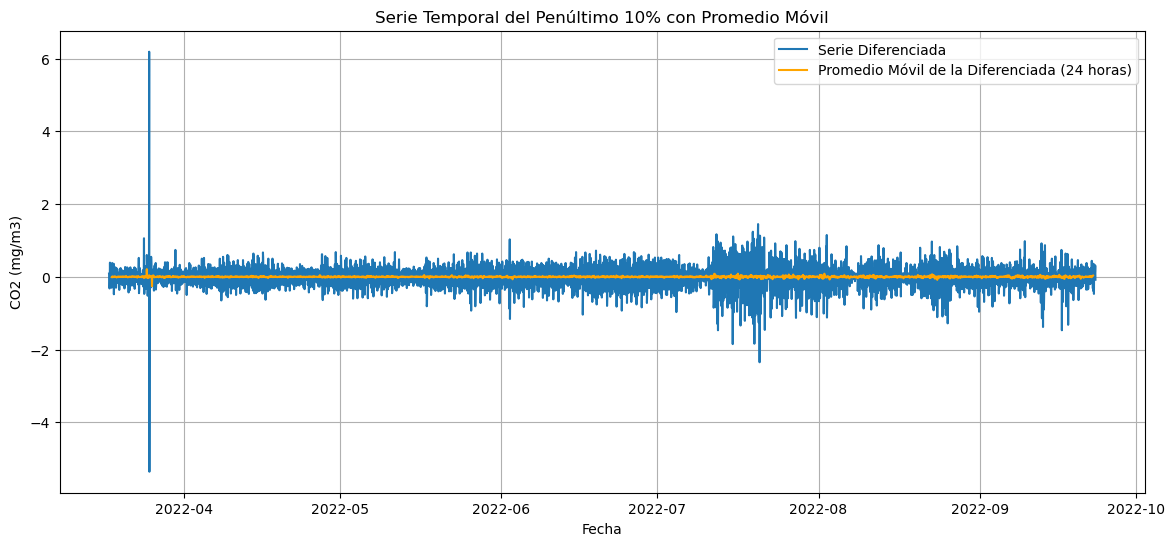

Performing stepwise search to minimize bic
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-25493.390, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=-26948.343, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=-27135.755, Time=0.40 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=-27251.299, Time=0.68 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=-27289.755, Time=1.25 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=-27281.455, Time=0.24 sec
 ARIMA(3,0,1)(0,0,0)[0]             : BIC=-27350.093, Time=2.37 sec
 ARIMA(3,0,0)(0,0,0)[0]             : BIC=-27309.683, Time=0.29 sec
 ARIMA(4,0,1)(0,0,0)[0]             : BIC=-27369.777, Time=0.63 sec
 ARIMA(4,0,0)(0,0,0)[0]             : BIC=-27428.381, Time=0.32 sec
 ARIMA(5,0,0)(0,0,0)[0]             : BIC=-27424.000, Time=1.08 sec
 ARIMA(5,0,1)(0,0,0)[0]             : BIC=-27455.207, Time=2.43 sec
 ARIMA(5,0,2)(0,0,0)[0]             : BIC=-27488.875, Time=2.70 sec
 ARIMA(4,0,2)(0,0,0)[0]             : BIC=-27375.896, Time=2.66 sec
 ARIM

In [13]:
# Paso 1: Extraer el penúltimo 10% de la serie
df_penultimo_decil = df[-int(0.2 * len(df)):-int(0.1 * len(df))]

# La serie sugiere diferenciación por ARIMA.
serie_diferenciada_penultima = df_penultimo_decil['CO2(mg/m3)'].diff().dropna()

# Paso 2: Comentar sobre la estacionalidad y removerla si es necesario
# Aplicar un filtro de promedio móvil para observar la estacionalidad
serie_promedio_movil_penultimo = serie_diferenciada_penultima.rolling(window=24, center=True).mean()

# Eliminar los valores NaN que resulten del promedio móvil
serie_promedio_movil_penultimo = serie_promedio_movil_penultimo.dropna()

# Graficar la serie diferenciada y el promedio móvil
plt.figure(figsize=(14, 6))
plt.plot(serie_diferenciada_penultima, label='Serie Diferenciada')
plt.plot(serie_promedio_movil_penultimo, label='Promedio Móvil de la Diferenciada (24 horas)', color='orange')
plt.title('Serie Temporal del Penúltimo 10% con Promedio Móvil')
plt.xlabel('Fecha')
plt.ylabel('CO2 (mg/m3)')
plt.legend()
plt.grid()
plt.show()

# Paso 3: Ajustar un modelo ARMA(p, q) usando auto_arima y justificar los parámetros
from pmdarima import auto_arima

modelo_auto_penultimo = auto_arima(
    serie_promedio_movil_penultimo,
    start_p=0,
    start_q=0,
    max_p=5,
    max_q=5,
    seasonal=False,
    trace=True,
    information_criterion='bic',
    stepwise=True
)

# Imprimir el resumen del modelo
print("Modelo ajustado al penúltimo 10% de la serie:")
print(modelo_auto_penultimo.summary())

# Imprimir los parámetros y criterios de AIC y BIC
print(f"El mejor modelo seleccionado es ARIMA({modelo_auto_penultimo.order}) con:")
print(f"AIC = {modelo_auto_penultimo.aic():.2f}")
print(f"BIC = {modelo_auto_penultimo.bic():.2f}")

# Paso 4: Realizar un test de raíces unitarias (Dickey-Fuller)
from statsmodels.tsa.stattools import adfuller

resultado_adf = adfuller(df_penultimo_decil['CO2(mg/m3)'].dropna())
print('\nResultados de la prueba Dickey-Fuller:')
print(f"Estadístico ADF: {resultado_adf[0]:.2f}")
print(f"p-valor: {resultado_adf[1]:.4f}")
if resultado_adf[1] <= 0.05:
    print("La serie es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La serie no es estacionaria (no podemos rechazar la hipótesis nula). Se recomienda una diferenciación.")


# Pregunta 5

In [15]:
# Comparar los modelos ajustados al penúltimo y último 10% de la serie
print("Comparación de los modelos ajustados:")
print(f"Modelo del penúltimo 10%: ARIMA({modelo_auto_penultimo.order}) con AIC = {modelo_auto_penultimo.aic():.2f} y BIC = {modelo_auto_penultimo.bic():.2f}")
print(f"Modelo del último 10%: ARIMA({modelo_auto_ultimo.order}) con AIC = {modelo_auto_ultimo.aic():.2f} y BIC = {modelo_auto_ultimo.bic():.2f}")

# Extraer los coeficientes de los modelos
coef_penultimo = modelo_auto_penultimo.params().dropna()
coef_ultimo = modelo_auto_ultimo.params().dropna()

# Prueba de igualdad de medias para los coeficientes de los modelos
print("\nPrueba de igualdad de medias para los coeficientes de los modelos:")
for param in coef_penultimo.index:
    if param in coef_ultimo.index:
        mean1 = coef_penultimo[param]
        mean2 = coef_ultimo[param]
        std1 = 0  # Establecer en 0 ya que es un valor único
        std2 = 0  # Establecer en 0 ya que es un valor único
        
        # Evitar calcular la prueba si ambos valores son iguales (tendrá p-valor NaN)
        if not np.isnan(mean1) and not np.isnan(mean2) and mean1 != mean2:
            t_stat, p_value = stats.ttest_ind_from_stats(
                mean1=mean1, std1=std1, nobs1=1,
                mean2=mean2, std2=std2, nobs2=1
            )
            print(f"\nParámetro {param}:")
            print(f"T-statistic: {t_stat:.2f}, p-value: {p_value:.4f}")
            if p_value < 0.05:
                print("Diferencia significativa en el parámetro entre los dos segmentos.")
            else:
                print("No hay diferencia significativa en el parámetro entre los dos segmentos.")
        else:
            print(f"\nParámetro {param}: No se realizó la prueba debido a valores iguales o NaN.")


Comparación de los modelos ajustados:
Modelo del penúltimo 10%: ARIMA((5, 0, 3)) con AIC = -27681.56 y BIC = -27623.80
Modelo del último 10%: ARIMA((4, 0, 0)) con AIC = -24844.28 y BIC = -24812.19

Prueba de igualdad de medias para los coeficientes de los modelos:

Parámetro ar.L1:
T-statistic: nan, p-value: nan
No hay diferencia significativa en el parámetro entre los dos segmentos.

Parámetro ar.L2:
T-statistic: nan, p-value: nan
No hay diferencia significativa en el parámetro entre los dos segmentos.

Parámetro ar.L3:
T-statistic: nan, p-value: nan
No hay diferencia significativa en el parámetro entre los dos segmentos.

Parámetro ar.L4:
T-statistic: nan, p-value: nan
No hay diferencia significativa en el parámetro entre los dos segmentos.

Parámetro sigma2:
T-statistic: nan, p-value: nan
No hay diferencia significativa en el parámetro entre los dos segmentos.
